In [1]:
# To Do
# * Data pre-processing [X]
#   * Figure out how play audio inside of a notebook using Ipython.display.audio [X]
#   * Cut your background clips to be 10 seconds (this is just to get everything working but we can expand later) [X]
#   * Set up Tx (# of time step inputs into the model), n_freq, Ty (number of outputs) [X]
#   * load positive, negative and backgrounds audios [X]
#   * build helper function get_random_time_segment (gets the random time segment) [X]
#   * build is_overlapping helper function [X]
#   * build insert_audio_clip that inserts an audio clip over the background noise at a random time step [X]
#   * build insert_ones which basically inserts 1s where there was a trigger word [X]
#   * build create_training_example which combines all of the functions from above and creates a training example [X]
#   * create a training dataset [X]




# Later when model is built but it's still kinda part of data pre processing
#   * create a helper class w/ helper functions []
#   * create a dev dataset []

## Importing Libs

In [2]:
import io
import os
import sys
import glob
import random
import IPython
import numpy as np


from td_utils import *
from pydub import AudioSegment

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, LSTM
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D

/home/nik/anaconda3/envs/tensorflowenv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Audio Samples

In [3]:
IPython.display.Audio("../data/positive/positive_1.wav")

In [4]:
IPython.display.Audio("../data/negative/negative_1.wav")

In [5]:
IPython.display.Audio("../data/background_noise/background_3_10.wav")

## Data pre-processing

In [6]:
# flow
# each background audio is 10 seconds long
# we will overlay positive/negative words on top of the background audio
# spectogram software converts a 10 second audio into 5598 time steps 
# we output 1375 timesteps
# I picked these input/output timesteps because they seem to be a standard in audio/speech recognition 

In [7]:
#t_x = #5598 #5511
t_x = 5511
n_freq = 101 # number of frequencies (generated by spectogram library)
t_y = 1375 # old t_y, we had to update because convolution
#t_y = 1496

In [8]:
os.listdir("../data/positive")

['positive_5.wav',
 'positive_14.wav',
 'positive_9.wav',
 'positive_22.wav',
 'positive_7.wav',
 'positive_2.wav',
 'positive_4.wav',
 'positive_16.wav',
 'positive_12.wav',
 'positive_15.wav',
 'positive_1.wav',
 'positive_13.wav',
 'positive_23.wav',
 'positive_6.wav',
 'positive_8.wav',
 'positive_21.wav',
 'positive_11.wav',
 'positive_17.wav',
 'positive_10.wav',
 'positive_19.wav',
 'positive_3.wav',
 'positive_18.wav',
 'positive_20.wav']

In [9]:
dir_name = "../data/positive/"

for file_name in os.listdir("../data/positive"):
    silent_audio = AudioSegment.silent(duration=10000)
    background = AudioSegment.from_wav(dir_name + file_name)
    background = silent_audio.overlay(background)
    background = background.set_frame_rate(44100)
    background.export(file_name, format="wav")

In [10]:
dir_name = "../data/negative/"

for file_name in os.listdir("../data/negative"):
    silent_audio = AudioSegment.silent(duration=10000)
    background = AudioSegment.from_wav(dir_name + file_name)
    background = silent_audio.overlay(background)
    background = background.set_frame_rate(44100)
    background.export(file_name, format="wav")

In [11]:
for background_f in ["../data/background_noise/background_1.wav", "../data/background_noise/background_2.wav", 
                   "../data/background_noise/background_3_10.wav", "../data/background_noise/background_4_10.wav",
                   "../data/background_noise/background_4_10.wav", "../data/background_noise/background_5_10.wav",
                   "../data/background_noise/background_6_10.wav"]:
    
    silent_audio = AudioSegment.silent(duration=10000)
    background = AudioSegment.from_wav(background_f)[:10000]
    background = silent_audio.overlay(background)
    background = background.set_frame_rate(44100)
    background.export(background_f, format="wav")

In [9]:
IPython.display.Audio("../data/positive/positive_1.wav")

In [10]:
IPython.display.Audio("../data/negative/negative_1.wav")

In [11]:
IPython.display.Audio("../data/background_noise/background_4_10.wav")

In [12]:
# help load audio files

def _load_audio_files(file_list, dirname):
    audio_files = []
    
    for file in file_list:
        audio_f = AudioSegment.from_wav(dirname + file)
        audio_files.append(audio_f)
        
    return audio_files

In [13]:
positives = _load_audio_files(os.listdir("../data/positive"), "../data/positive/")
negatives = _load_audio_files(os.listdir("../data/negative"), "../data/negative/")

In [14]:
# for some reason ffmpeg errors out if I use the utils function I wrote. So I'm loading background audio manually

backgrounds = []

f1 = AudioSegment.from_wav("../data/background_noise/background_1.wav")
backgrounds.append(f1)

f2 = AudioSegment.from_wav("../data/background_noise/background_2.wav")
backgrounds.append(f2)

f3 = AudioSegment.from_wav("../data/background_noise/background_3_10.wav")
backgrounds.append(f3)

f4 = AudioSegment.from_wav("../data/background_noise/background_4_10.wav")
backgrounds.append(f4)

f5 = AudioSegment.from_wav("../data/background_noise/background_5_10.wav")
backgrounds.append(f5)

f6 = AudioSegment.from_wav("../data/background_noise/background_6_10.wav")
backgrounds.append(f6)

In [15]:
len(positives), len(negatives), len(backgrounds)

(23, 28, 6)

In [16]:
np.random.randint(low=0, high=10)

8

In [17]:
# get random time segment from a provided audio length
# we only support 10s length for now (backgrounds are 10s long)

def _random_time_segment(audio_length_ms):    
    start_segment = np.random.randint(low=0, high=10000-audio_length_ms)
    
    end_segment = start_segment + audio_length_ms - 1
    
    return start_segment, end_segment

In [18]:
_random_time_segment(5000)

(3635, 8634)

In [19]:
# check if overlayed audio overalps

def _is_overlapping(segment, previous_segments):
    is_overlapping = False
    
    start_time_segment, end_time_segment = segment
    
    for p_start, p_end in previous_segments:
        if start_time_segment <= p_end and end_time_segment >= p_start:
            is_overlapping = True
    
    return is_overlapping

In [20]:
_is_overlapping((100, 200), [(50, 300)])

True

In [21]:
# overlay audio clip over the background

def _insert_audio_clip(background, audio_clip, previous_segments):
    audio_clip_length = len(audio_clip)
    random_segment_time = _random_time_segment(audio_clip_length)
    
    while _is_overlapping(random_segment_time, previous_segments):
        random_segment_time = _random_time_segment(audio_clip_length)
        
    previous_segments.append(random_segment_time)
    new_background = background.overlay(audio_clip, position=random_segment_time[0])
    
    return new_background, random_segment_time

In [25]:
audio_clip, segment_time = _insert_audio_clip(backgrounds[0], positives[0], [(3790, 4400)])

In [22]:
# update Y labels based on where the trigger word was said (segmend_end_ms) 
# we add 50 1s after the trigger word is said

def _insert_ones(y, segment_end_ms):
    segment_end_y = int(segment_end_ms*t_y/10000.0) # figure out where segmend ended in terms of Ys
    
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < t_y: #make sure it doesn't go over Ty
            y[0, i] = 1
    
    return y

In [23]:
arr1 = _insert_ones(np.zeros((1, t_y)), 3000)

In [24]:
arr1

array([[0., 0., 0., ..., 0., 0., 0.]])

In [25]:
unique, counts = np.unique(arr1[0], return_counts=True)
dict(zip(unique, counts))

{0.0: 1325, 1.0: 50}

In [26]:
def _create_a_training_example(background, positives, negatives, save_file=False):
    background = background - 20 # we make the background quieter in case its too loud
    y = np.zeros((1, t_y))
    previous_segments = []
    
    # get 0-4 positive examples
    number_of_positives_to_overlay = np.random.randint(0, 5)
    random_positives_indices = np.random.randint(len(positives), size=number_of_positives_to_overlay)
    random_positives = [positives[i] for i in random_positives_indices]
    
    # overlay positive over background
    for positive in random_positives:
        background, random_time_segment = _insert_audio_clip(background, positive, previous_segments)
        _, random_time_segment_end = random_time_segment
        y = _insert_ones(y, random_time_segment_end)
        
    
    # get 0-2 negative examples
    number_of_negatives_to_overlay = np.random.randint(0, 3)
    random_negatives_indices = np.random.randint(len(negatives), size=number_of_negatives_to_overlay)
    random_negatives = [negatives[i] for i in random_negatives_indices]
    
    #overlay negatives
    for negative in random_negatives:
        background, random_time_segment = _insert_audio_clip(background, negative, previous_segments)
        
    background = match_target_amplitude(background, -20.0) #standardize amplitude of the background
        

    random_file_number = np.random.randint(100000)
    background = background.set_frame_rate(44100)
    file_name = background.export(f'train_{random_file_number}.wav', format="wav")

    return file_name.name, graph_spectrogram(file_name.name), y 

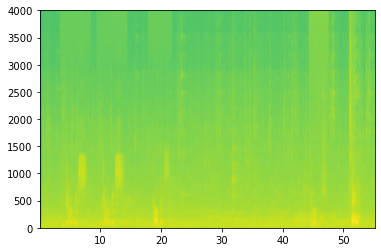

In [27]:
fname, x, y = _create_a_training_example(backgrounds[5], positives, negatives)

In [28]:
x.shape

(101, 5511)

In [29]:
y.shape

(1, 1375)

In [30]:
x = x.swapaxes(0,1)

In [31]:
x.shape

(5511, 101)

In [32]:
x = np.expand_dims(x, axis=0)

In [33]:
x.shape

(1, 5511, 101)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

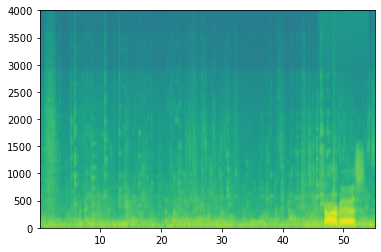

In [34]:
X = []
Y = []

for i in range(1500):
    fname, x, y = _create_a_training_example(backgrounds[np.random.randint(5)], positives, negatives)
    print(i)
    x = x.swapaxes(0, 1)
    x = np.expand_dims(x, axis=0)
    X.append(x)
    Y.append(y)
    #os.remove(fname)

In [35]:
X[0].shape

(1, 5511, 101)

In [36]:
X = np.vstack(X)
Y = np.vstack(Y)

In [37]:
X.shape

(1500, 5511, 101)

In [38]:
Y.shape

(1500, 1375)

In [39]:
np.save("X_train_2.npy", X)

In [40]:
np.save("Y_train_2.npy", Y)

In [4]:
X = np.load("X_train.npy")

In [6]:
X.shape

(2109, 5998, 101)